In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rsicd-image-caption-dataset/valid.csv
/kaggle/input/rsicd-image-caption-dataset/train.csv
/kaggle/input/rsicd-image-caption-dataset/test.csv


In [ ]:
import pandas as pd
import numpy as np
import ast
import os
from PIL import Image
import io
from tqdm import tqdm


In [ ]:
DATA_DIR = "/kaggle/input/rsicd-image-caption-dataset"
OUT_DIR = "/kaggle/working"

os.makedirs(f"{OUT_DIR}/images", exist_ok=True)


In [ ]:
train_df = pd.read_csv(f"{DATA_DIR}/train.csv")
val_df   = pd.read_csv(f"{DATA_DIR}/valid.csv")
test_df  = pd.read_csv(f"{DATA_DIR}/test.csv")

print("Train:", train_df.shape)
print("Val  :", val_df.shape)
print("Test :", test_df.shape)


Train: (8734, 3)
Val  : (1094, 3)
Test : (1093, 3)


In [ ]:
train_df.columns

Index(['filename', 'captions', 'image'], dtype='object')

In [ ]:
train_df

,filename,captions,image
0,rsicd_images/airport_1.jpg,['Many aircraft are parked next to a long buil...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1,rsicd_images/airport_10.jpg,['some planes are parked in an airport.'\n 'th...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2,rsicd_images/airport_100.jpg,['Many aircraft are parked in an airport near ...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
3,rsicd_images/airport_101.jpg,['Many aircraft are parked near a large buildi...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
4,rsicd_images/airport_102.jpg,['several buildings and green trees are around...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
...,...,...,...
8729,rsicd_images/00914.jpg,['the majestic polygonal baseball field can co...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
8730,rsicd_images/00915.jpg,['the baseball field is near the residential a...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
8731,rsicd_images/00916.jpg,"['on the side of the road, there are two baseb...",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
8732,rsicd_images/00918.jpg,['this is a huge baseball field decorated with...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...


In [ ]:
train_df['captions'][0]

"['Many aircraft are parked next to a long building in an airport.'\n 'Many planes are parked next to a long building at an airport.'\n 'Many planes are parked next to a long building in an airport.'\n 'many planes are parked next to a long building at an airport.'\n 'many planes are parked next to a long building in an airport .']"

In [ ]:
def count_captions(df):
    return df["captions"].apply(lambda x: len(ast.literal_eval(x))).describe()

count_captions(train_df)


count    8734.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: captions, dtype: float64

In [ ]:
def caption_lengths(df):
    lens = []
    for caps in df["captions"]:
        caps = ast.literal_eval(caps)
        for c in caps:
            lens.append(len(c.split()))
    return pd.Series(lens).describe()

caption_lengths(train_df)


count    8734.000000
mean       52.017632
std        13.715673
min        20.000000
25%        42.000000
50%        51.000000
75%        60.000000
max       118.000000
dtype: float64

In [ ]:
def extract_images(df, split):
    out_path = f"{OUT_DIR}/images/{split}"
    os.makedirs(out_path, exist_ok=True)

    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_bytes = eval(row["image"])["bytes"]
        img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
        img_name = row["filename"].split("/")[-1]
        img.save(f"{out_path}/{img_name}")


In [ ]:
extract_images(train_df, "train")
extract_images(val_df, "val")
extract_images(test_df, "test")

100%|██████████| 1093/1093 [00:03<00:00, 341.49it/s]


In [ ]:
def parse_captions(caption_str):
    # remove surrounding brackets
    caption_str = caption_str.strip()[1:-1]

    # split by newline
    captions = caption_str.split("\n")

    # clean each caption
    captions = [
        c.strip().strip("'").strip('"')
        for c in captions
        if len(c.strip()) > 0
    ]

    return captions


In [ ]:
example = train_df.iloc[0]["captions"]
parsed = parse_captions(example)

print(len(parsed))
for c in parsed:
    print("-", c)


5
- Many aircraft are parked next to a long building in an airport.
- Many planes are parked next to a long building at an airport.
- Many planes are parked next to a long building in an airport.
- many planes are parked next to a long building at an airport.
- many planes are parked next to a long building in an airport .


In [ ]:
import ast
import pandas as pd

OUT_DIR = "/kaggle/working"

def flatten_dataset(df, split):
    rows = []

    for _, row in df.iterrows():
        img_name = row["filename"].split("/")[-1]
        img_path = f"/kaggle/working/images/{split}/{img_name}"

        captions = parse_captions(row["captions"])

        for cap in captions:
            rows.append({
                "image_path": img_path,
                "caption": cap.lower().strip()
            })

    return pd.DataFrame(rows)

train_flat = flatten_dataset(train_df, "train")
val_flat   = flatten_dataset(val_df, "val")
test_flat  = flatten_dataset(test_df, "test")

train_flat.to_csv("/kaggle/working/train_clip.csv", index=False)
val_flat.to_csv("/kaggle/working/val_clip.csv", index=False)
test_flat.to_csv("/kaggle/working/test_clip.csv", index=False)


In [ ]:
assert train_flat["image_path"].apply(os.path.exists).all()
assert train_flat["caption"].str.len().mean() > 30

In [ ]:
!zip -r images_archive.zip /kaggle/working/images

  adding: kaggle/working/images/ (stored 0%)
  adding: kaggle/working/images/train/ (stored 0%)
  adding: kaggle/working/images/train/river_136.jpg (deflated 2%)
  adding: kaggle/working/images/train/forest_186.jpg (deflated 2%)
  adding: kaggle/working/images/train/airport_246.jpg (deflated 2%)
  adding: kaggle/working/images/train/beach_161.jpg (deflated 2%)
  adding: kaggle/working/images/train/mediumresidential_260.jpg (deflated 1%)
  adding: kaggle/working/images/train/playground_275.jpg (deflated 2%)
  adding: kaggle/working/images/train/sparseresidential_245.jpg (deflated 1%)
  adding: kaggle/working/images/train/meadow_198.jpg (deflated 2%)
  adding: kaggle/working/images/train/viaduct_243.jpg (deflated 1%)
  adding: kaggle/working/images/train/park_292.jpg (deflated 1%)
  adding: kaggle/working/images/train/square_178.jpg (deflated 1%)
  adding: kaggle/working/images/train/industrial_165.jpg (deflated 1%)
  adding: kaggle/working/images/train/00315.jpg (deflated 1%)
  adding: 

In [ ]:
!pip install -q transformers torch torchvision accelerate

In [ ]:
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel


2026-02-16 09:25:18.256554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771233918.443015      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771233918.499906      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771233918.949475      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771233918.949518      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771233918.949521      55 computation_placer.cc:177] computation placer alr

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
print("Number of GPUs:", torch.cuda.device_count())

Device: cuda
Number of GPUs: 2


In [ ]:
train_df = pd.read_csv("/kaggle/working/train_clip.csv")
val_df   = pd.read_csv("/kaggle/working/val_clip.csv")

print("Train samples:", len(train_df))
print("Val samples:", len(val_df))


Train samples: 42548
Val samples: 5148


In [ ]:
train_df = pd.read_csv("/kaggle/working/train_clip.csv")
val_df   = pd.read_csv("/kaggle/working/val_clip.csv")

print("Train samples:", len(train_df))
print("Val samples:", len(val_df))


Train samples: 42548
Val samples: 5148


In [ ]:
train_df

,image_path,caption
0,/kaggle/working/images/train/airport_1.jpg,many aircraft are parked next to a long buildi...
1,/kaggle/working/images/train/airport_1.jpg,many planes are parked next to a long building...
2,/kaggle/working/images/train/airport_1.jpg,many planes are parked next to a long building...
3,/kaggle/working/images/train/airport_1.jpg,many planes are parked next to a long building...
4,/kaggle/working/images/train/airport_1.jpg,many planes are parked next to a long building...
...,...,...
42543,/kaggle/working/images/train/00920.jpg,two baseball fields are located in the huage a...
42544,/kaggle/working/images/train/00920.jpg,two baseball fields are in one side of a road .
42545,/kaggle/working/images/train/00920.jpg,two baseball grounds are next to a road and a ...
42546,/kaggle/working/images/train/00920.jpg,two baseball fields are next to a road and a p...


In [ ]:
class CLIPDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df.reset_index(drop=True)
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image = Image.open(row["image_path"]).convert("RGB")
        caption = row["caption"]

        inputs = self.processor(
            images=image,
            text=caption,
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )

        return {
            "pixel_values": inputs["pixel_values"].squeeze(0),
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0)
        }


In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
if torch.cuda.device_count() > 1:
    print("Using DataParallel with", torch.cuda.device_count(), "GPUs")
    model = torch.nn.DataParallel(model)

model = model.to(device)

Using DataParallel with 2 GPUs


In [ ]:
train_dataset = CLIPDataset(train_df, processor)
val_dataset   = CLIPDataset(val_df, processor)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


In [ ]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-5,
    weight_decay=1e-4
)


In [ ]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0

    for batch in tqdm(loader):
        optimizer.zero_grad()

        outputs = model(
            pixel_values=batch["pixel_values"].to(device),
            input_ids=batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device),
            return_loss=True
        )

        loss = outputs.loss.mean()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [ ]:
def validate_one_epoch(model, loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            outputs = model(
                pixel_values=batch["pixel_values"].to(device),
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device),
                return_loss=True
            )

            loss = outputs.loss.mean()
            total_loss += loss.item()

    return total_loss / len(loader)


In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader)
    val_loss   = validate_one_epoch(model, val_loader)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val   Loss: {val_loss:.4f}")


  0%|          | 0/1330 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
100%|██████████| 1330/1330 [09:14<00:00,  2.40it/s]



Epoch 1/5
Train Loss: 0.3938
Val   Loss: 2.8645


100%|██████████| 1330/1330 [09:28<00:00,  2.34it/s]



Epoch 2/5
Train Loss: 0.2192
Val   Loss: 3.0310


100%|██████████| 1330/1330 [09:28<00:00,  2.34it/s]



Epoch 3/5
Train Loss: 0.1703
Val   Loss: 3.0474


100%|██████████| 1330/1330 [09:28<00:00,  2.34it/s]



Epoch 4/5
Train Loss: 0.1418
Val   Loss: 3.1864


100%|██████████| 1330/1330 [09:26<00:00,  2.35it/s]



Epoch 5/5
Train Loss: 0.1182
Val   Loss: 3.3528


In [ ]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPModel, CLIPProcessor
from tqdm import tqdm
from PIL import Image
import os
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Dataset
class CLIPDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image = Image.open(row["image_path"]).convert("RGB")
        caption = row["caption"]

        return {
            "image": image,
            "caption": caption
        }


def collate_fn(batch):
    images = [item["image"] for item in batch]
    captions = [item["caption"] for item in batch]

    inputs = processor(
        text=captions,
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True
    )

    return {
        "pixel_values": inputs["pixel_values"],
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"]
    }


# Load Data
train_df = pd.read_csv("/kaggle/working/train_clip.csv")
val_df   = pd.read_csv("/kaggle/working/val_clip.csv")

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)

# Freeze Text Encoder
for param in model.text_model.parameters():
    param.requires_grad = False

print("Text encoder frozen.")
print("Trainable params:",
      sum(p.numel() for p in model.parameters() if p.requires_grad))

# DataLoader
train_dataset = CLIPDataset(train_df)
val_dataset   = CLIPDataset(val_df)


train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)


# Optimizer + Scheduler
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-6,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=10
)

# Training Functions
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0

    for batch in tqdm(loader):
        optimizer.zero_grad()

        outputs = model(
            pixel_values=batch["pixel_values"].to(DEVICE),
            input_ids=batch["input_ids"].to(DEVICE),
            attention_mask=batch["attention_mask"].to(DEVICE),
            return_loss=True
        )

        loss = outputs.loss.mean()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def validate_one_epoch(model, loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            outputs = model(
                pixel_values=batch["pixel_values"].to(DEVICE),
                input_ids=batch["input_ids"].to(DEVICE),
                attention_mask=batch["attention_mask"].to(DEVICE),
                return_loss=True
            )

            loss = outputs.loss.mean()
            total_loss += loss.item()

    return total_loss / len(loader)




Text encoder frozen.
Trainable params: 88111361


In [ ]:
# Training Loop with Early Stop
EPOCHS = 10
best_val_loss = float("inf")
patience = 3
early_stop_counter = 0

for epoch in range(EPOCHS):

    train_loss = train_one_epoch(model, train_loader)
    val_loss   = validate_one_epoch(model, val_loader)

    scheduler.step()

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val   Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0

        print("Saving best model...")
        model.save_pretrained("clip-rsicd")
        processor.save_pretrained("clip-rsicd")

    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break


 57%|█████▋    | 764/1330 [04:25<03:16,  2.88it/s]


KeyboardInterrupt: 

In [ ]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPModel, CLIPProcessor
from tqdm import tqdm
from PIL import Image
import os

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_GPUS = torch.cuda.device_count()

print("Using device:", DEVICE)
print("GPUs available:", NUM_GPUS)

# Dataset
class CLIPDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["image_path"]).convert("RGB")
        caption = row["caption"]

        return {
            "image": image,
            "caption": caption
        }

# Collate Function
def collate_fn(batch):
    images = [item["image"] for item in batch]
    captions = [item["caption"] for item in batch]

    inputs = processor(
        text=captions,
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True
    )

    return {
        "pixel_values": inputs["pixel_values"],
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"]
    }

# Load Data
train_df = pd.read_csv("/kaggle/working/train_clip.csv")
val_df   = pd.read_csv("/kaggle/working/val_clip.csv")

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Freeze Text Encoder
for param in model.text_model.parameters():
    param.requires_grad = False

print("Text encoder frozen.")

# Multi-GPU Setup
if NUM_GPUS > 1:
    print("Using DataParallel on", NUM_GPUS, "GPUs")
    model = torch.nn.DataParallel(model)

model = model.to(DEVICE)

# DataLoader
train_dataset = CLIPDataset(train_df)
val_dataset   = CLIPDataset(val_df)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)

# Optimizer + Scheduler
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-6,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=10
)

# Train / Validate
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0

    for batch in tqdm(loader):
        optimizer.zero_grad()

        outputs = model(
            pixel_values=batch["pixel_values"].to(DEVICE),
            input_ids=batch["input_ids"].to(DEVICE),
            attention_mask=batch["attention_mask"].to(DEVICE),
            return_loss=True
        )

        loss = outputs.loss.mean()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def validate_one_epoch(model, loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            outputs = model(
                pixel_values=batch["pixel_values"].to(DEVICE),
                input_ids=batch["input_ids"].to(DEVICE),
                attention_mask=batch["attention_mask"].to(DEVICE),
                return_loss=True
            )

            loss = outputs.loss.mean()
            total_loss += loss.item()

    return total_loss / len(loader)

Using device: cuda
GPUs available: 2
Text encoder frozen.
Using DataParallel on 2 GPUs


In [ ]:
# Training Loop

EPOCHS = 10
best_val_loss = float("inf")
patience = 3
early_stop_counter = 0

for epoch in range(EPOCHS):

    train_loss = train_one_epoch(model, train_loader)
    val_loss   = validate_one_epoch(model, val_loader)

    scheduler.step()

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val   Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0

        print("Saving best model...")

        # Handle DataParallel saving correctly
        if NUM_GPUS > 1:
            model.module.save_pretrained("clip-rsicd")
        else:
            model.save_pretrained("clip-rsicd")

        processor.save_pretrained("clip-rsicd")

    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break

  0%|          | 0/1330 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
100%|██████████| 1330/1330 [07:01<00:00,  3.15it/s]



Epoch 1/10
Train Loss: 0.4897
Val   Loss: 2.9585
Saving best model...


100%|██████████| 1330/1330 [07:02<00:00,  3.15it/s]



Epoch 2/10
Train Loss: 0.2706
Val   Loss: 3.0926


100%|██████████| 1330/1330 [07:02<00:00,  3.15it/s]



Epoch 3/10
Train Loss: 0.1918
Val   Loss: 3.2189


100%|██████████| 1330/1330 [07:02<00:00,  3.15it/s]



Epoch 4/10
Train Loss: 0.1463
Val   Loss: 3.2072
Early stopping triggered.


In [ ]:
save_path = "/kaggle/working/clip-rsicd"

if isinstance(model, torch.nn.DataParallel):
    model.module.save_pretrained(save_path)
else:
    model.save_pretrained(save_path)

processor.save_pretrained(save_path)

print("Model saved to:", save_path)


Model saved to: /kaggle/working/clip-rsicd


In [ ]:
!zip -r clip-rsicd.zip /kaggle/working/clip-rsicd

  adding: kaggle/working/clip-rsicd/ (stored 0%)
  adding: kaggle/working/clip-rsicd/special_tokens_map.json (deflated 78%)
  adding: kaggle/working/clip-rsicd/model.safetensors (deflated 16%)
  adding: kaggle/working/clip-rsicd/tokenizer_config.json (deflated 63%)
  adding: kaggle/working/clip-rsicd/preprocessor_config.json (deflated 50%)
  adding: kaggle/working/clip-rsicd/vocab.json (deflated 62%)
  adding: kaggle/working/clip-rsicd/merges.txt (deflated 60%)
  adding: kaggle/working/clip-rsicd/config.json (deflated 66%)
  adding: kaggle/working/clip-rsicd/tokenizer.json (deflated 83%)


In [ ]:
import torch
from transformers import CLIPModel, CLIPProcessor
from PIL import Image
import pandas as pd

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CLIPModel.from_pretrained("/kaggle/working/clip-rsicd")
processor = CLIPProcessor.from_pretrained("/kaggle/working/clip-rsicd")

model = model.to(device)
model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [ ]:
val_df = pd.read_csv("/kaggle/working/val_clip.csv")

# unique images only
image_paths = val_df["image_path"].unique()

In [ ]:
import numpy as np
from tqdm import tqdm

image_embeddings = []

with torch.no_grad():
    for img_path in tqdm(image_paths):
        image = Image.open(img_path).convert("RGB")

        inputs = processor(images=image, return_tensors="pt").to(device)
        emb = model.get_image_features(**inputs)

        emb = emb / emb.norm(dim=-1, keepdim=True)
        image_embeddings.append(emb.cpu())

image_embeddings = torch.cat(image_embeddings)

100%|██████████| 1094/1094 [00:09<00:00, 116.37it/s]


In [ ]:
query = "an airport with multiple airplanes and multiple runway"
# query = "industrial buildings near roads"
# query = "an airport with a single runway"


inputs = processor(text=query, return_tensors="pt").to(device)

with torch.no_grad():
    text_emb = model.get_text_features(**inputs)
    text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)


In [ ]:
# normalize already done
text_emb = text_emb.cpu()

similarities = (text_emb @ image_embeddings.T).squeeze(0)

top_k = similarities.topk(5).indices.tolist()

top_k_image_paths = []
for idx in top_k:
    print(image_paths[idx])
    top_k_image_paths.append(image_paths[idx])


/kaggle/working/images/val/airport_94.jpg
/kaggle/working/images/val/airport_93.jpg
/kaggle/working/images/val/airport_61.jpg
/kaggle/working/images/val/airport_95.jpg
/kaggle/working/images/val/airport_98.jpg


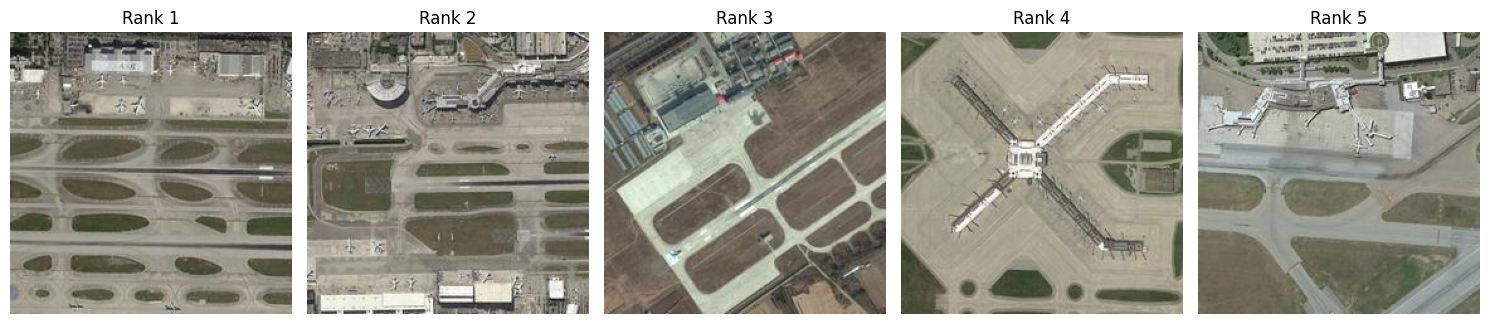

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

retrieved_paths = top_k_image_paths

plt.figure(figsize=(15, 5))

for i, path in enumerate(retrieved_paths):
    img = Image.open(path).convert("RGB")
    plt.subplot(1, len(retrieved_paths), i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Rank {i+1}")

plt.tight_layout()
plt.show()


In [ ]:
!pip install gdown

In [ ]:
!gdown --id 1jY3C0NmKvAkov_nTPjyKqqZrO3tN_OOd

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1jY3C0NmKvAkov_nTPjyKqqZrO3tN_OOd
From (redirected): https://drive.google.com/uc?id=1jY3C0NmKvAkov_nTPjyKqqZrO3tN_OOd&confirm=t&uuid=5c498e65-8105-419d-81f7-dee9c2c9ad61
To: /kaggle/working/clip-rsicd.zip
100%|████████████████████████████████████████| 562M/562M [00:06<00:00, 83.4MB/s]


In [ ]:
!unzip -q /kaggle/working/clip-rsicd.zip -d /

In [ ]:
import torch
from transformers import CLIPModel, CLIPProcessor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

2026-02-13 10:09:18.586196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770977358.981219      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770977359.088809      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770977360.039320      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770977360.039358      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770977360.039361      55 computation_placer.cc:177] computation placer alr

In [ ]:
import transformers
print(transformers.__version__)


4.57.1


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CLIPModel.from_pretrained("/kaggle/working/clip-rsicd").to(device)
processor = CLIPProcessor.from_pretrained("/kaggle/working/clip-rsicd")

model.eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

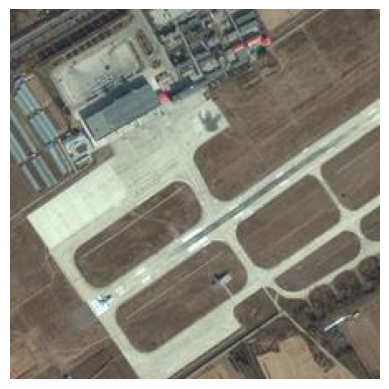

In [ ]:
image_path = "/kaggle/working/images/val/airport_61.jpg"
image = Image.open(image_path).convert("RGB")

plt.imshow(image)
plt.axis("off")


In [ ]:
# Split image into regions (GRID SPLIT)
# 4×4 grid
def split_into_regions(image, grid_size=4):
    w, h = image.size
    regions = []
    boxes = []

    dw = w // grid_size
    dh = h // grid_size

    for i in range(grid_size):
        for j in range(grid_size):
            left = j * dw
            upper = i * dh
            right = (j + 1) * dw
            lower = (i + 1) * dh

            crop = image.crop((left, upper, right, lower))
            regions.append(crop)
            boxes.append((left, upper, right, lower))

    return regions, boxes

regions, boxes = split_into_regions(image, grid_size=4)
len(regions)

16

In [ ]:
# Embed ALL regions using CLIP

region_embeddings = []

with torch.no_grad():
    for region in regions:
        inputs = processor(images=region, return_tensors="pt").to(device)
        emb = model.get_image_features(**inputs)
        emb = emb / emb.norm(dim=-1, keepdim=True)
        region_embeddings.append(emb.cpu())

region_embeddings = torch.cat(region_embeddings)

In [ ]:
# Encode user query (THIS IS RAG QUERY)

query = "airport building"

inputs = processor(text=query, return_tensors="pt").to(device)

with torch.no_grad():
    text_emb = model.get_text_features(**inputs)
    text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)

text_emb = text_emb.cpu()


In [ ]:
# Retrieve TOP-K regions (THIS IS RETRIEVAL)

similarities = (text_emb @ region_embeddings.T).squeeze(0)

top_k = 6
top_indices = similarities.topk(top_k).indices.tolist()
top_indices


[2, 3, 1, 0, 4, 12]

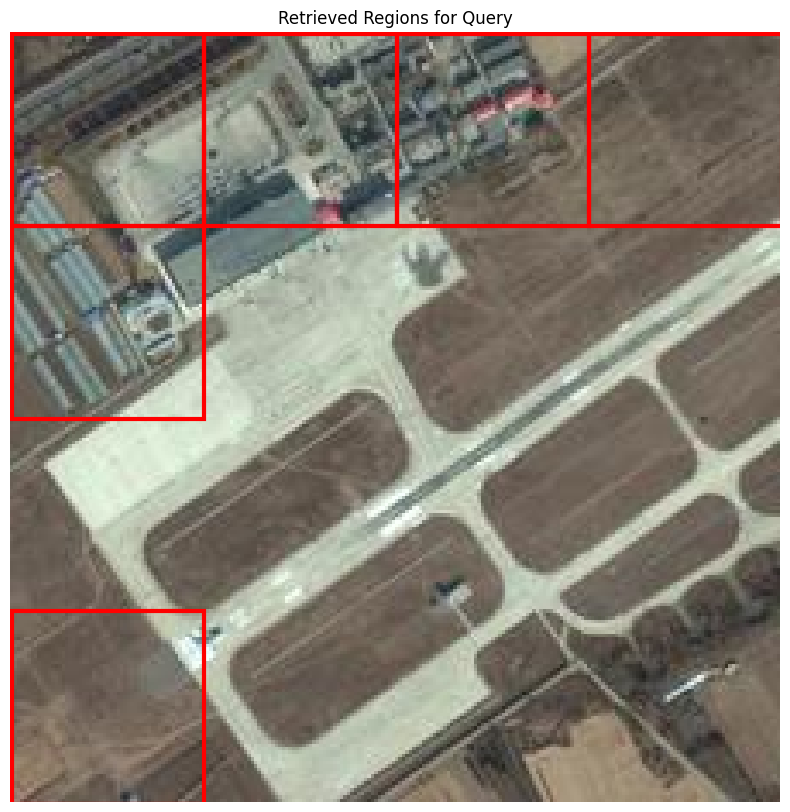

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")

ax = plt.gca()

for idx in top_indices:
    left, top, right, bottom = boxes[idx]
    rect = plt.Rectangle(
        (left, top),
        right - left,
        bottom - top,
        fill=False,
        edgecolor="red",
        linewidth=3
    )
    ax.add_patch(rect)

plt.title("Retrieved Regions for Query")
plt.show()


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from transformers import CLIPModel, CLIPProcessor

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load Model
print("Loading model...")
model = CLIPModel.from_pretrained("/kaggle/working/clip-rsicd").to(DEVICE)
processor = CLIPProcessor.from_pretrained("/kaggle/working/clip-rsicd")
model.eval()

# Fix Kaggle → Local Path
def normalize_path(path):
    if "/kaggle/working/" in path:
        return path.replace("/kaggle/working/", "")
    return path

# Encode Single Image
def encode_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        emb = model.get_image_features(**inputs)

    emb = emb / emb.norm(dim=-1, keepdim=True)
    return emb.cpu()

# Encode Text
def encode_text(text):
    inputs = processor(text=text, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        emb = model.get_text_features(**inputs)

    emb = emb / emb.norm(dim=-1, keepdim=True)
    return emb.cpu()

# Evaluation Function
def evaluate(csv_path):

    print("\n==============================")
    print(f"Evaluating: {csv_path}")
    print("==============================")

    df = pd.read_csv(csv_path)

    # Normalize paths
    df["image_path"] = df["image_path"].apply(normalize_path)

    # Unique images
    unique_images = df["image_path"].unique()
    image_to_index = {img: idx for idx, img in enumerate(unique_images)}

    # Encode All Images Once
    print("Encoding images...")
    image_embeddings = []

    for img_path in tqdm(unique_images):
        image_embeddings.append(encode_image(img_path))

    image_embeddings = torch.cat(image_embeddings)  # [N_images, 512]

    # Metrics
    r1 = 0
    r5 = 0
    r10 = 0
    mrr = 0

    print("Evaluating captions...")

    for _, row in tqdm(df.iterrows(), total=len(df)):

        caption = row["caption"]
        true_image = row["image_path"]
        true_index = image_to_index[true_image]

        text_emb = encode_text(caption)  # [1, 512]

        sims = (text_emb @ image_embeddings.T).squeeze(0)
        ranked_indices = torch.argsort(sims, descending=True)

        rank_position = (ranked_indices == true_index).nonzero(as_tuple=True)[0].item() + 1

        if rank_position <= 1:
            r1 += 1
        if rank_position <= 5:
            r5 += 1
        if rank_position <= 10:
            r10 += 1

        mrr += 1.0 / rank_position

    total = len(df)

    print("\nResults:")
    print(f"Total Queries : {total}")
    print(f"Recall@1      : {r1/total:.4f}")
    print(f"Recall@5      : {r5/total:.4f}")
    print(f"Recall@10     : {r10/total:.4f}")
    print(f"MRR           : {mrr/total:.4f}")
    print("==============================\n")
if __name__ == "__main__":

    evaluate("/kaggle/working/val_clip.csv")
    evaluate("/kaggle/working/test_clip.csv")


Loading model...

Evaluating: /kaggle/working/val_clip.csv
Encoding images...


100%|██████████| 1094/1094 [00:09<00:00, 113.04it/s]


Evaluating captions...


100%|██████████| 5148/5148 [00:42<00:00, 122.55it/s]



Results:
Total Queries : 5148
Recall@1      : 0.0824
Recall@5      : 0.2809
Recall@10     : 0.4316
MRR           : 0.1923


Evaluating: /kaggle/working/test_clip.csv
Encoding images...


100%|██████████| 1093/1093 [00:09<00:00, 117.03it/s]


Evaluating captions...


100%|██████████| 5419/5419 [00:44<00:00, 121.48it/s]


Results:
Total Queries : 5419
Recall@1      : 0.0943
Recall@5      : 0.2999
Recall@10     : 0.4684
MRR           : 0.2079

